# **Loading data**

In [39]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, \
                                        LogisticRegressionModel, RandomForestClassificationModel, GBTClassificationModel
from time import time

spark = SparkSession.builder.appName('SIMARGL2021').getOrCreate()

# **Data preprocessing**

In [19]:
base_df = spark.read.csv("SIMARGL2021.csv", header=True, inferSchema=True)
base_df.show(2)

+----------------+---------+-----------------------+--------------+--------------+-------------------+--------------------------+--------------------------+---------------------+------------+--------+---------------------+-----------------------+--------------+------------+--------+-------+--------------+--------------+-----------+-----------+-------------+--------------+--------------+---------------+----------------+---------+--------+--------+------------+----------------------+---------------------+-----------------------+----------------------+-----------------------+---------+--------------+---------------+--------------+---------------+--------------+---------------+----------------+-----------------+-------+-------+--------------+-----------------+---------------+-----------+
|BIFLOW_DIRECTION|DIRECTION|DST_TO_SRC_SECOND_BYTES|FIREWALL_EVENT|FIRST_SWITCHED|FLOW_ACTIVE_TIMEOUT|FLOW_DURATION_MICROSECONDS|FLOW_DURATION_MILLISECONDS|FLOW_END_MILLISECONDS|FLOW_END_SEC| FLOW_ID|FLOW_

In [20]:
base_df = base_df.withColumn("Label", when(base_df.LABEL == "Normal flow", 0).otherwise(1))
base_df.drop("LABEL")

df = base_df
df.printSchema()

root
 |-- BIFLOW_DIRECTION: integer (nullable = true)
 |-- DIRECTION: integer (nullable = true)
 |-- DST_TO_SRC_SECOND_BYTES: string (nullable = true)
 |-- FIREWALL_EVENT: integer (nullable = true)
 |-- FIRST_SWITCHED: integer (nullable = true)
 |-- FLOW_ACTIVE_TIMEOUT: integer (nullable = true)
 |-- FLOW_DURATION_MICROSECONDS: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- FLOW_END_MILLISECONDS: long (nullable = true)
 |-- FLOW_END_SEC: integer (nullable = true)
 |-- FLOW_ID: integer (nullable = true)
 |-- FLOW_INACTIVE_TIMEOUT: integer (nullable = true)
 |-- FLOW_START_MILLISECONDS: long (nullable = true)
 |-- FLOW_START_SEC: integer (nullable = true)
 |-- FRAME_LENGTH: integer (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- IPV4_DST_ADDR: string (nullable = true)
 |-- IPV4_SRC_ADDR: string (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- L4_SRC_PORT: integer (nullable

In [21]:
df.count()

8637207

In [22]:
df2 = df.na.drop()
df2.count()

8637207

In [23]:
from pyspark.ml.feature import StringIndexer

si = StringIndexer(inputCols=["IPV4_SRC_ADDR", "IPV4_DST_ADDR", "PROTOCOL_MAP", "L7_PROTO_NAME"], outputCols=["IPV4_SRC_ADDR_Index", "IPV4_DST_ADDR_Index", "PROTOCOL_MAP_Index", "L7_PROTO_NAME_Index"])
si_fit = si.fit(df)


df_indexed = si_fit.transform(df)

In [24]:
df = df_indexed.drop("IPV4_SRC_ADDR", "IPV4_DST_ADDR", "DST_TO_SRC_SECOND_BYTES", "PROTOCOL_MAP", "SRC_TO_DST_SECOND_BYTES", "L7_PROTO_NAME", "BIFLOW_DIRECTION", "DIRECTION", "FLOW_ACTIVE_TIMEOUT", "FIREWALL_EVENT", "FLOW_INACTIVE_TIMEOUT", "FRAME_LENGTH", "MAX_IP_PKT_LEN", "MIN_IP_PKT_LEN", "SAMPLING_INTERVAL", "FLOW_START_SEC", "FLOW_END_SEC", "FLOW_DURATION_MICROSECONDS", "FLOW_ID", "OOORDER_IN_PKTS", "OOORDER_OUT_PKTS")
df.printSchema()

root
 |-- FIRST_SWITCHED: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- FLOW_END_MILLISECONDS: long (nullable = true)
 |-- FLOW_START_MILLISECONDS: long (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- L4_SRC_PORT: integer (nullable = true)
 |-- LAST_SWITCHED: integer (nullable = true)
 |-- OUT_BYTES: long (nullable = true)
 |-- OUT_PKTS: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- RETRANSMITTED_IN_BYTES: integer (nullable = true)
 |-- RETRANSMITTED_IN_PKTS: integer (nullable = true)
 |-- RETRANSMITTED_OUT_BYTES: integer (nullable = true)
 |-- RETRANSMITTED_OUT_PKTS: integer (nullable = true)
 |-- TCP_FLAGS: integer (nullable = true)
 |-- TCP_WIN_MAX_IN: integer (nullable = true)
 |-- TCP_WIN_MAX_OUT: integer (nullable = true)
 |-- TCP_WIN_MIN_IN: integer (nullable = true)
 |-- TCP_WIN_MIN_OUT: integer (nullable = tru

# Correlation Matrix

In [25]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

corr = Correlation.corr(df_vector, vector_col)

matrix = corr.collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df.columns, index=df.columns) 
corr_matrix_df.style.background_gradient(cmap='coolwarm')

,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,FLOW_END_MILLISECONDS,FLOW_START_MILLISECONDS,IN_BYTES,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,OUT_BYTES,OUT_PKTS,PROTOCOL,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,TCP_FLAGS,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_MSS_OUT,TCP_WIN_SCALE_IN,TCP_WIN_SCALE_OUT,SRC_TOS,DST_TOS,TOTAL_FLOWS_EXP,Label,IPV4_SRC_ADDR_Index,IPV4_DST_ADDR_Index,PROTOCOL_MAP_Index,L7_PROTO_NAME_Index
FIRST_SWITCHED,1.000000,0.162694,0.999997,1.000000,-0.006413,-0.004517,-0.051627,-0.041850,0.999997,-0.001023,-0.002079,-0.131243,-0.024126,0.010513,0.011986,0.012259,0.174129,0.082339,0.118535,0.082912,0.118995,0.062505,0.192049,0.051354,0.204915,-0.061782,-0.097314,0.950147,0.253776,-0.048534,-0.020652,-0.173386,-0.080895
FLOW_DURATION_MILLISECONDS,0.162694,1.000000,0.165094,0.162694,0.014288,0.019655,-0.216952,-0.053719,0.165093,0.004375,0.007986,-0.302953,0.044909,0.384324,-0.011223,-0.011038,0.423331,0.000326,0.039940,0.001416,0.040517,-0.043160,0.099153,-0.027111,0.113693,-0.173051,-0.152401,0.122318,0.745828,-0.099859,-0.123444,-0.362969,-0.181945
FLOW_END_MILLISECONDS,0.999997,0.165094,1.000000,0.999997,-0.006375,-0.004467,-0.052141,-0.041966,1.000000,-0.001012,-0.002059,-0.131938,-0.024006,0.011456,0.011953,0.012227,0.175103,0.082307,0.118586,0.082883,0.119047,0.062373,0.192217,0.051267,0.205113,-0.062184,-0.097651,0.950065,0.255512,-0.048760,-0.020948,-0.174211,-0.081311
FLOW_START_MILLISECONDS,1.000000,0.162694,0.999997,1.000000,-0.006413,-0.004517,-0.051627,-0.041850,0.999997,-0.001023,-0.002080,-0.131243,-0.024126,0.010513,0.011986,0.012259,0.174129,0.082339,0.118535,0.082913,0.118995,0.062505,0.192050,0.051354,0.204915,-0.061782,-0.097314,0.950147,0.253775,-0.048534,-0.020652,-0.173386,-0.080895
IN_BYTES,-0.006413,0.014288,-0.006375,-0.006413,1.000000,0.803119,0.006779,-0.002362,-0.006375,0.063159,0.210766,0.003860,0.034934,0.020215,0.004842,0.004839,0.000170,0.003532,0.016583,0.003457,0.016546,0.002821,0.005620,0.002721,0.005824,-0.003528,-0.000139,-0.006463,-0.008775,-0.000895,-0.001927,0.000653,0.027399
IN_PKTS,-0.004517,0.019655,-0.004467,-0.004517,0.803119,1.000000,0.005942,-0.003057,-0.004467,0.571169,0.707349,0.002161,0.026904,0.016319,0.084243,0.084185,0.003884,0.006605,0.020426,0.006431,0.020365,0.005301,0.010040,0.005249,0.010244,-0.004870,-0.000363,-0.004553,-0.007928,-0.001497,-0.003171,-0.002150,0.030731
L4_DST_PORT,-0.051627,-0.216952,-0.052141,-0.051627,0.006779,0.005942,1.000000,-0.054245,-0.052141,0.001190,0.001252,0.205233,-0.009005,-0.062357,-0.010545,-0.010313,-0.167271,-0.103364,-0.210682,-0.102250,-0.210528,-0.088296,-0.235629,-0.088218,-0.245189,0.049643,0.014460,-0.054896,-0.320873,0.095110,0.465629,0.080574,0.004016
L4_SRC_PORT,-0.041850,-0.053719,-0.041966,-0.041850,-0.002362,-0.003057,-0.054245,1.000000,-0.041966,-0.000740,-0.001013,0.234348,0.004136,0.044342,-0.006856,-0.007472,0.028641,0.086947,0.022572,0.085792,0.022285,0.084763,-0.000466,0.095595,-0.008663,-0.215387,0.132924,-0.052349,-0.041638,-0.098551,0.105494,-0.247178,0.032835
LAST_SWITCHED,0.999997,0.165093,1.000000,0.999997,-0.006375,-0.004467,-0.052141,-0.041966,1.000000,-0.001012,-0.002059,-0.131937,-0.024006,0.011456,0.011953,0.012227,0.175102,0.082307,0.118586,0.082883,0.119047,0.062374,0.192217,0.051267,0.205113,-0.062184,-0.097651,0.950065,0.255512,-0.048760,-0.020948,-0.174211,-0.081311
OUT_BYTES,-0.001023,0.004375,-0.001012,-0.001023,0.063159,0.571169,0.001190,-0.000740,-0.001012,1.000000,0.931187,-0.000981,0.001086,-0.000351,0.143005,0.143121,0.003783,0.006209,0.012077,0.005869,0.012055,0.005275,0.007564,0.004865,0.007477,-0.001900,-0.000317,-0.000830,-0.006408,-0.000441,-0.001051,-0.002562,0.010524


In [26]:
final_df = df.select(["FLOW_DURATION_MILLISECONDS", "TCP_FLAGS", "TCP_WIN_MAX_IN", "TCP_WIN_MIN_IN", "TCP_WIN_MSS_OUT", "TCP_WIN_SCALE_OUT", "Label"])
final_df.show(5)

+--------------------------+---------+--------------+--------------+---------------+-----------------+-----+
|FLOW_DURATION_MILLISECONDS|TCP_FLAGS|TCP_WIN_MAX_IN|TCP_WIN_MIN_IN|TCP_WIN_MSS_OUT|TCP_WIN_SCALE_OUT|Label|
+--------------------------+---------+--------------+--------------+---------------+-----------------+-----+
|                    104116|       19|         64240|          8192|           1460|                0|    0|
|                      9529|        0|             0|             0|              0|                0|    0|
|                      9529|        0|             0|             0|              0|                0|    0|
|                         0|        0|             0|             0|              0|                0|    0|
|                         0|        2|         65535|         65535|              0|                0|    0|
+--------------------------+---------+--------------+--------------+---------------+-----------------+-----+
only showing top 5 

In [27]:
final_df.repartition(1).write.option("header", True).csv("df")

# **ML Algorithms**

## Proessed data load

In [28]:
df = spark.read.csv("processedData.csv", header=True, inferSchema=True)
df.show(5)

+--------------------------+---------+--------------+--------------+---------------+-----------------+-----+
|FLOW_DURATION_MILLISECONDS|TCP_FLAGS|TCP_WIN_MAX_IN|TCP_WIN_MIN_IN|TCP_WIN_MSS_OUT|TCP_WIN_SCALE_OUT|Label|
+--------------------------+---------+--------------+--------------+---------------+-----------------+-----+
|                    104116|       19|         64240|          8192|           1460|                0|    0|
|                      9529|        0|             0|             0|              0|                0|    0|
|                      9529|        0|             0|             0|              0|                0|    0|
|                         0|        0|             0|             0|              0|                0|    0|
|                         0|        2|         65535|         65535|              0|                0|    0|
+--------------------------+---------+--------------+--------------+---------------+-----------------+-----+
only showing top 5 

Assemble vector

In [29]:
df = df.limit(8_500_000)

input_cols = df.columns
input_cols.remove("Label")

assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
output = assembler.transform(df)

final_data = output.select(["features", "Label"])

Training data and testing data split

In [30]:
trainData, testData = final_data.randomSplit([0.7, 0.3], seed = 16)

In [31]:
trainData.describe().show()
testData.describe().show()

+-------+-------------------+
|summary|              Label|
+-------+-------------------+
|  count|            5950730|
|   mean|0.36961213162082635|
| stddev|0.48269974407932525|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

+-------+-------------------+
|summary|              Label|
+-------+-------------------+
|  count|            2549270|
|   mean|0.36933671207835966|
| stddev|0.48262531694852406|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



## **Logistic Regression**

In [32]:
lr = LogisticRegression(labelCol='Label')

startTime = time()

lr_model = lr.fit(trainData)

endTime = time()
print(f"{endTime - startTime} seconds")

50.052526235580444 seconds


In [33]:
lr_model.save("LR_Model")

In [34]:
lr_model = LogisticRegressionModel.load("LR_Model")

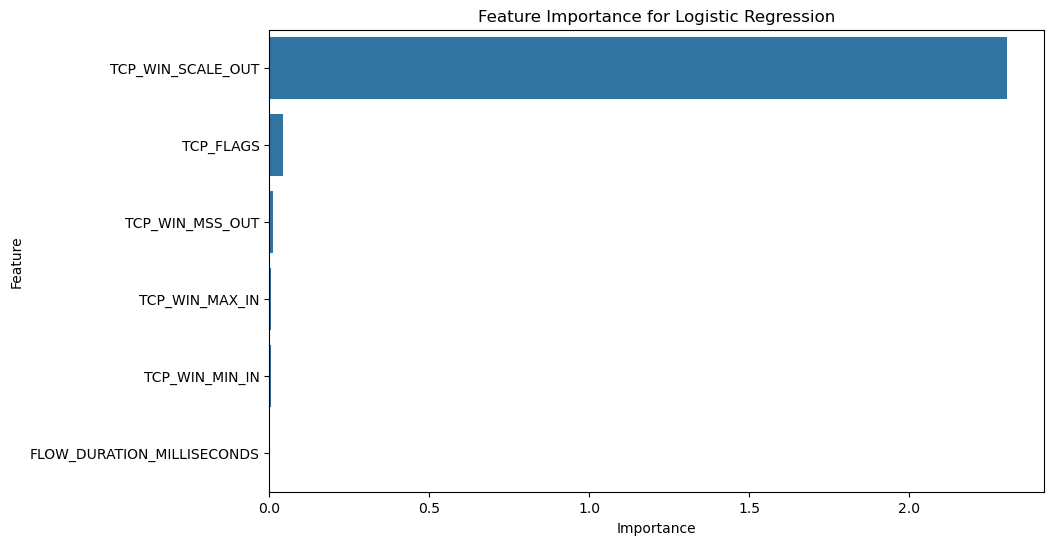

In [35]:
coefficients = lr_model.coefficientMatrix.toArray()

feature_names = ["FLOW_DURATION_MILLISECONDS", "TCP_FLAGS", "TCP_WIN_MAX_IN", "TCP_WIN_MIN_IN", "TCP_WIN_MSS_OUT", "TCP_WIN_SCALE_OUT"]

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(coefficients).sum(axis=0)
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance for Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Metrics

In [36]:
predictions = lr_model.transform(testData)
predictions.show()

+---------+-----+--------------------+--------------------+----------+
| features|Label|       rawPrediction|         probability|prediction|
+---------+-----+--------------------+--------------------+----------+
|(6,[],[])|    0|[4.14747482994267...|[0.98444161437857...|       0.0|
|(6,[],[])|    0|[4.14747482994267...|[0.98444161437857...|       0.0|
|(6,[],[])|    0|[4.14747482994267...|[0.98444161437857...|       0.0|
|(6,[],[])|    0|[4.14747482994267...|[0.98444161437857...|       0.0|
|(6,[],[])|    0|[4.14747482994267...|[0.98444161437857...|       0.0|
|(6,[],[])|    0|[4.14747482994267...|[0.98444161437857...|       0.0|
|(6,[],[])|    0|[4.14747482994267...|[0.98444161437857...|       0.0|
|(6,[],[])|    0|[4.14747482994267...|[0.98444161437857...|       0.0|
|(6,[],[])|    0|[4.14747482994267...|[0.98444161437857...|       0.0|
|(6,[],[])|    0|[4.14747482994267...|[0.98444161437857...|       0.0|
|(6,[],[])|    0|[4.14747482994267...|[0.98444161437857...|       0.0|
|(6,[]

In [40]:
predictions = predictions.withColumn("prediction", predictions["prediction"].cast(IntegerType()))
predictions = predictions.withColumn("result", F.when((predictions["prediction"] == 1) & (predictions["Label"] == 1), 0) \
                                                .when((predictions["prediction"] == 0) & (predictions["Label"] == 1), 1) \
                                                .when((predictions["prediction"] == 1) & (predictions["Label"] == 0), 2) \
                                                .otherwise(3))

tp = predictions.filter(predictions["result"] == 0).count()
fp = predictions.filter(predictions["result"] == 1).count()
fn = predictions.filter(predictions["result"] == 2).count()
tn = predictions.filter(predictions["result"] == 3).count()

print(
f"True Positives: {tp}\n \
False Positives: {fp}\n \
False Negatives: {fn}\n \
True Negatives: {tn}"
)

True Positives: 769422
 False Positives: 172117
 False Negatives: 150086
 True Negatives: 1457645


In [41]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

print(
f"Accuracy: {accuracy}\n \
Precision: {precision}\n \
Recall: {recall}\n \
F1-Score: {f1_score}"
)

Accuracy: 0.8736097000317739
 Precision: 0.8171961012767395
 Recall: 0.8367757539901773
 F1-Score: 0.8268700360603467


## **Random Forest Classifier**

In [43]:
rf = RandomForestClassifier(labelCol='Label')

startTime = time()

rf_model = rf.fit(trainData)

endTime = time()
print(f"{endTime - startTime} seconds")

123.05704045295715 seconds


Model Checkpoint

In [44]:
rf_model.save("RF_Model")

In [45]:
rf_model = RandomForestClassificationModel.load("RF_Model")

Feature importance

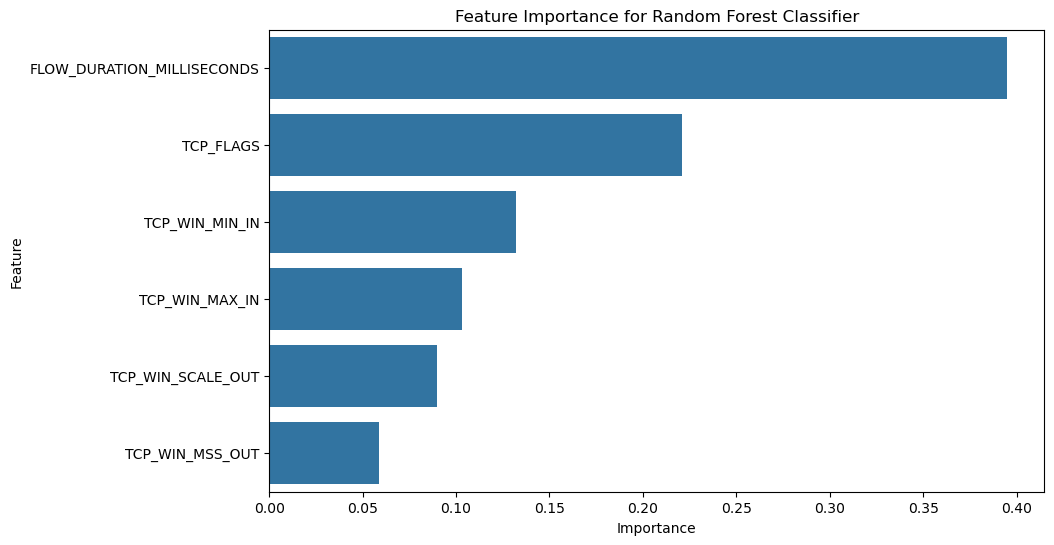

In [46]:
importances = rf_model.featureImportances.toArray()
feature_names = ["FLOW_DURATION_MILLISECONDS", "TCP_FLAGS", "TCP_WIN_MAX_IN", "TCP_WIN_MIN_IN", "TCP_WIN_MSS_OUT", "TCP_WIN_SCALE_OUT"]

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance for Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Metrics computation

In [47]:
predictions = rf_model.transform(testData)
predictions = predictions.withColumn("prediction", predictions["prediction"].cast(IntegerType()))

predictions = predictions.withColumn("result", F.when((predictions["prediction"] == 1) & (predictions["Label"] == 1), 0) \
                                                .when((predictions["prediction"] == 0) & (predictions["Label"] == 1), 1) \
                                                .when((predictions["prediction"] == 1) & (predictions["Label"] == 0), 2) \
                                                .otherwise(3))

tp = predictions.filter(predictions["result"] == 0).count()
fp = predictions.filter(predictions["result"] == 1).count()
fn = predictions.filter(predictions["result"] == 2).count()
tn = predictions.filter(predictions["result"] == 3).count()

print(
f"True Positives: {tp}\n \
False Positives: {fp}\n \
False Negatives: {fn}\n \
True Negatives: {tn}"
)

True Positives: 940187
 False Positives: 1352
 False Negatives: 18571
 True Negatives: 1589160


In [48]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

print(
f"Accuracy: {accuracy}\n \
Precision: {precision}\n \
Recall: {recall}\n \
F1-Score: {f1_score}"
)

Accuracy: 0.9921848215371459
 Precision: 0.9985640531087931
 Recall: 0.9806301485880692
 F1-Score: 0.9895158493645992


## **Gradient-Boosted Tree**

In [49]:
gbt = GBTClassifier(labelCol='Label')

startTime = time()

gbt_model = gbt.fit(trainData)

endTime = time()
print(f"{endTime - startTime} seconds")

473.55415987968445 seconds


Model checkpoint

In [52]:
gbt_model.save("GBT_Model")

In [53]:
gbt_model = GBTClassificationModel.load("GBT_Model")

Feature importance

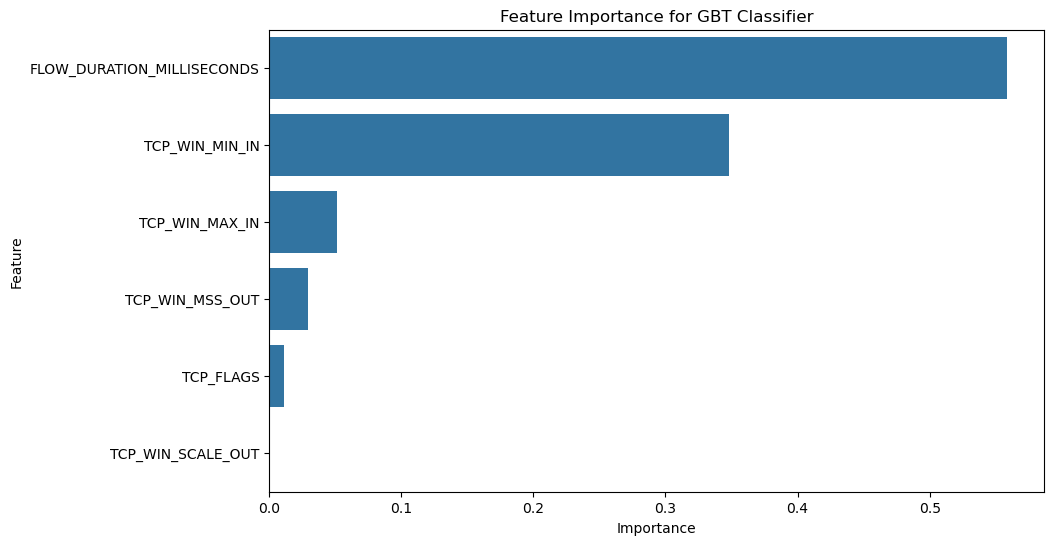

In [54]:
importances = gbt_model.featureImportances.toArray()
feature_names = ["FLOW_DURATION_MILLISECONDS", "TCP_FLAGS", "TCP_WIN_MAX_IN", "TCP_WIN_MIN_IN", "TCP_WIN_MSS_OUT", "TCP_WIN_SCALE_OUT"] 

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance for GBT Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [56]:
predictions = gbt_model.transform(testData)
predictions = predictions.withColumn("prediction", predictions["prediction"].cast(IntegerType()))

predictions = predictions.withColumn("result", F.when((predictions["prediction"] == 1) & (predictions["Label"] == 1), 0) \
                                                .when((predictions["prediction"] == 0) & (predictions["Label"] == 1), 1) \
                                                .when((predictions["prediction"] == 1) & (predictions["Label"] == 0), 2) \
                                                .otherwise(3))

tp = predictions.filter(predictions["result"] == 0).count()
fp = predictions.filter(predictions["result"] == 1).count()
fn = predictions.filter(predictions["result"] == 2).count()
tn = predictions.filter(predictions["result"] == 3).count()

print(
f"True Positives: {tp}\n \
False Positives: {fp}\n \
False Negatives: {fn}\n \
True Negatives: {tn}"
)

True Positives: 940800
 False Positives: 739
 False Negatives: 10332
 True Negatives: 1597399


In [57]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

print(
f"Accuracy: {accuracy}\n \
Precision: {precision}\n \
Recall: {recall}\n \
F1-Score: {f1_score}"
)

Accuracy: 0.9956571881362115
 Precision: 0.9992151148279572
 Recall: 0.9891371544643646
 F1-Score: 0.9941505945829995
